In [2]:
%matplotlib inline


from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel

import numpy as np

import msmexplorer as msme

rs = np.random.RandomState(42)

In [4]:
from msmbuilder.dataset import dataset
import os
import mdtraj as mdt
import glob


cwd = os.getcwd()
print(cwd)

## Load
trajs = dataset("*SC*.xtc", topology="md.loop_SC_start.gro")
    
for traj in trajs:
    print(traj)

/Users/sbamos/Documents/WORK/MSM
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>


Extract dihedrals

In [6]:
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = featurizer.fit_transform(trajs)

Preprocess

In [7]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(diheds)

Dimensionality reduction

/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


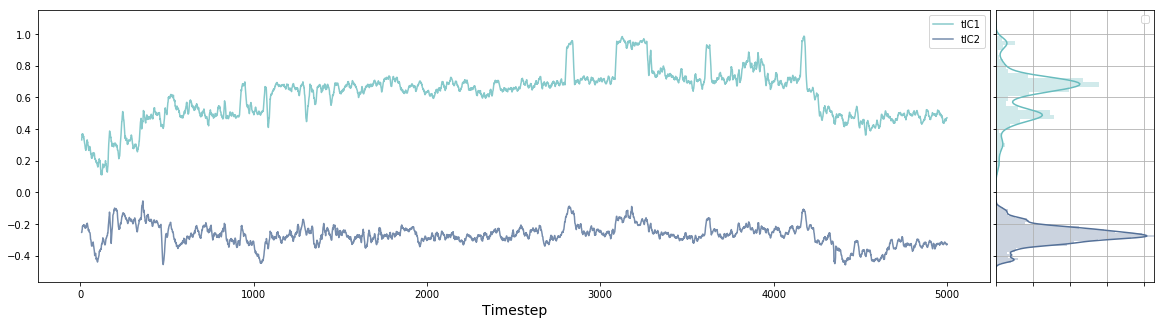

In [193]:
tica_model = tICA(lag_time=10, n_components=2, kinetic_mapping=True)
tica_trajs = tica_model.fit_transform(scaled_data)

ax, side_ax = msme.plot_trace(tica_trajs[0][:, 0], window=10,
                              label='tIC1', xlabel='Timestep')
_ = msme.plot_trace(tica_trajs[0][:, 1], window=10, label='tIC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)

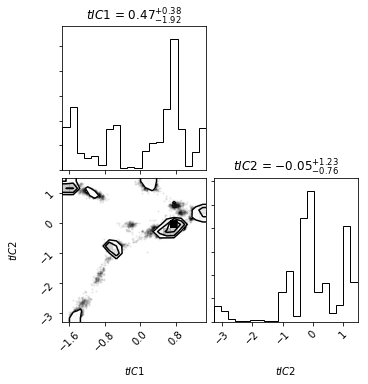

In [195]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx, labels=['$tIC1$', '$tIC2$'],
                    show_titles=True)

Perform clustering

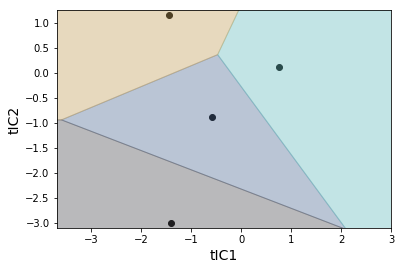

In [118]:
clusterer = MiniBatchKMeans(n_clusters=4, random_state=rs)
clustered_trajs = clusterer.fit_transform(tica_trajs)

_ = msme.plot_voronoi(clusterer, xlabel='tIC1', ylabel='tIC2')

Construct MSM

MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


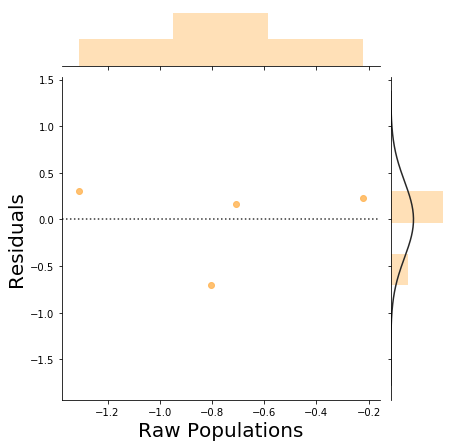

In [133]:
msm = MarkovStateModel(lag_time=100, n_timescales=5)
assigns = msm.fit_transform(clustered_trajs)

_ = msme.plot_pop_resids(msm, color='tarragon')

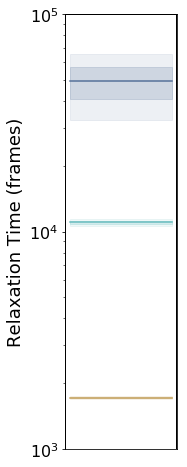

In [134]:
_ = msme.plot_timescales(msm, ylabel=r'Relaxation Time (frames)')

Validation

In [181]:
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=5, verbose=False)
                     for x in [1, 5, 25, 125]
]

for msm in msm_list:
    msm.fit(clustered_trajs)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


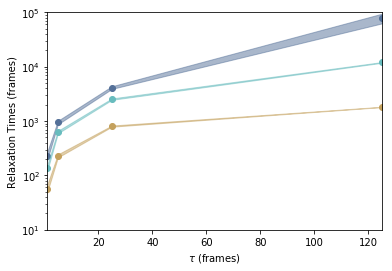

In [182]:
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

In [183]:
msm = msm_list[2]  # Choose the appropriate MSM from the list

In [184]:
for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts * 50 / 1000
    uncertainty_ns = ts_u * 50 / 1000
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

Timescale 1: 207.08 ± 11.48 ns
Timescale 2: 126.84 ± 3.65 ns
Timescale 3: 40.43 ± 0.96 ns


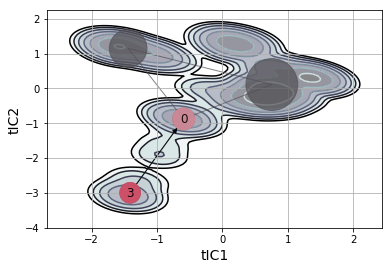

In [187]:
data = np.concatenate(tica_trajs, axis=0)
pi_0 = msm.populations_[np.concatenate(assigns, axis=0)]


# Free Energy Surface
ax = msme.plot_free_energy(data, obs=(0, 1), n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=5.,
                          n_levels=8, cut=5, xlabel='tIC1',
                          ylabel='tIC2', random_state=rs)

# MSM Network
pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)


# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['rawdenim', 'lightgrey', 'pomegranate'])
_ = msme.plot_tpaths(msm, [3], [0], pos=pos, node_color=cmap(w),
                     alpha=.9, edge_color='black', ax=ax)